In [1]:
# This file is used for comparsion with COMPSOC voting rules vs the RUMSA and MCEM
# Test profiles will be generated from COMPSOC sdk with several distributions, then scores of result and std deviation will be measured.

In [2]:
import compsoc.voter_model as vmodel
import compsoc.evaluate as eval
import compsoc.voting_rules as rules
from compsoc.profile import Profile
import matplotlib.pyplot as plt
import Aggregation.sampling as sp
import numpy as np
import random

game list loaded


In [3]:
# profiles are all 100 voters and 10 candidates
rand_profiles = [Profile(vmodel.generate_random_votes(number_voters=100, number_candidates=5)) for _ in range(10)]
diri_profiles = [Profile(vmodel.generate_multinomial_dirichlet_votes(alpha=[random.random() for _ in range(5)], num_candidates=5, num_voters=100)) for _ in range(10)]

In [4]:
# function for convertion of two formats' 
def prof_list_to_tuple(profile):
    temp = []
    for p in profile:
        temp.append(tuple(p))
    dic = dict()
    for t in temp:
        if t not in dic.keys():
            dic[t] = 1
        else:
            dic[t] += 1
    result = []
    for k in dic.keys():
        result.append((dic[k], k))
    return result

def prof_tuple_to_list(profile):
    result = []
    for i in profile:
        for j in range(i[0]):
            result.append(list(i[1]))
    random.shuffle(result)
    return result

In [5]:
# generate gaussian profiles
norm_profiles = []

for _ in range(10):
    # generate true utility for each 
    alternatives = list(range(5))
    utilities = [sp.random_normal_distribution(0, 3) for _ in range(5)]

    # generate ballots
    ballots = []
    for _ in range(100):
        personal_util = [sp.random_normal_distribution(u, 1) for u in utilities]
        ballots.append(sp.order_generation(personal_util))

    ballots = prof_list_to_tuple(ballots)
    norm_profiles.append(Profile(ballots))

In [6]:
# define sampling algorithm
def rumsa(profile, candidate):

    schedule = []
    for _ in range(10):
        schedule.append((0.5,0.8))
    for _ in range(10):
        schedule.append((0.3, 0.5))
    for _ in range(20):
        schedule.append((0.1, 0.05))

    temp = profile.pairs.copy()
    ballots = prof_tuple_to_list(temp)
    number_cand = len(ballots[0])
    logs = sp.theta_estimation(ballots, number_cand, iteration=40, sampling_rate=200, keep_rate=40, resampling_schedule=schedule, verbose=False)
    return logs[39]["theta_estimation"][candidate]

In [7]:
# def random rule which just return random social order
def random_rule(profile, candidate):
    return random.random()

In [8]:
test_rules = {
    "Borda": rules.borda.borda_rule,
    "Borda_gamma_0.01": rules.borda_gamma.get_borda_gamma(0.01),
    "Borda_gamma_0.25": rules.borda_gamma.get_borda_gamma(0.25),
    "Borda_gamma_0.5": rules.borda_gamma.get_borda_gamma(0.5),
    "Borda_gamma_0.75": rules.borda_gamma.get_borda_gamma(0.75),
    "Borda_gamma_0.99": rules.borda_gamma.get_borda_gamma(0.99),
    "Borda_gamma_1.00": rules.borda_gamma.get_borda_gamma(1.0),
    "Copeland": rules.copeland.copeland_rule,
    "Dowdall": rules.dowdall.dowdall_rule,
    "Simpson": rules.simpson.simpson_rule,
    "RUMSA": rumsa,
    "Random": random_rule,
}

In [9]:
rand_results = dict()
for k in test_rules.keys():
    rand_results[k] = []

for rule in test_rules.keys():
    for i in range(10):
        score = eval.get_rule_utility(rand_profiles[i], rule=test_rules[rule], topn=2)
        rand_results[rule].append(score)
    print(f"rule {rule} finished")


rule Borda finished
rule Borda_gamma_0.01 finished
rule Borda_gamma_0.25 finished
rule Borda_gamma_0.5 finished
rule Borda_gamma_0.75 finished
rule Borda_gamma_0.99 finished
rule Borda_gamma_1.00 finished
rule Copeland finished
rule Dowdall finished
rule Simpson finished
rule RUMSA finished
rule Random finished


In [10]:
diri_results = dict()
for k in test_rules.keys():
    diri_results[k] = []

for rule in test_rules.keys():
    for i in range(10):
        score = eval.get_rule_utility(diri_profiles[i], rule=test_rules[rule], topn=2)
        diri_results[rule].append(score)
    print(f"rule {rule} finished")

rule Borda finished
rule Borda_gamma_0.01 finished
rule Borda_gamma_0.25 finished
rule Borda_gamma_0.5 finished
rule Borda_gamma_0.75 finished
rule Borda_gamma_0.99 finished
rule Borda_gamma_1.00 finished
rule Copeland finished
rule Dowdall finished
rule Simpson finished
rule RUMSA finished
rule Random finished


In [11]:
norm_results = dict()
for k in test_rules.keys():
    norm_results[k] = []

for rule in test_rules.keys():
    for i in range(10):
        score = eval.get_rule_utility(norm_profiles[i], rule=test_rules[rule], topn=2)
        norm_results[rule].append(score)
    print(f"rule {rule} finished")

rule Borda finished
rule Borda_gamma_0.01 finished
rule Borda_gamma_0.25 finished
rule Borda_gamma_0.5 finished
rule Borda_gamma_0.75 finished
rule Borda_gamma_0.99 finished
rule Borda_gamma_1.00 finished
rule Copeland finished
rule Dowdall finished
rule Simpson finished
rule RUMSA finished
rule Random finished


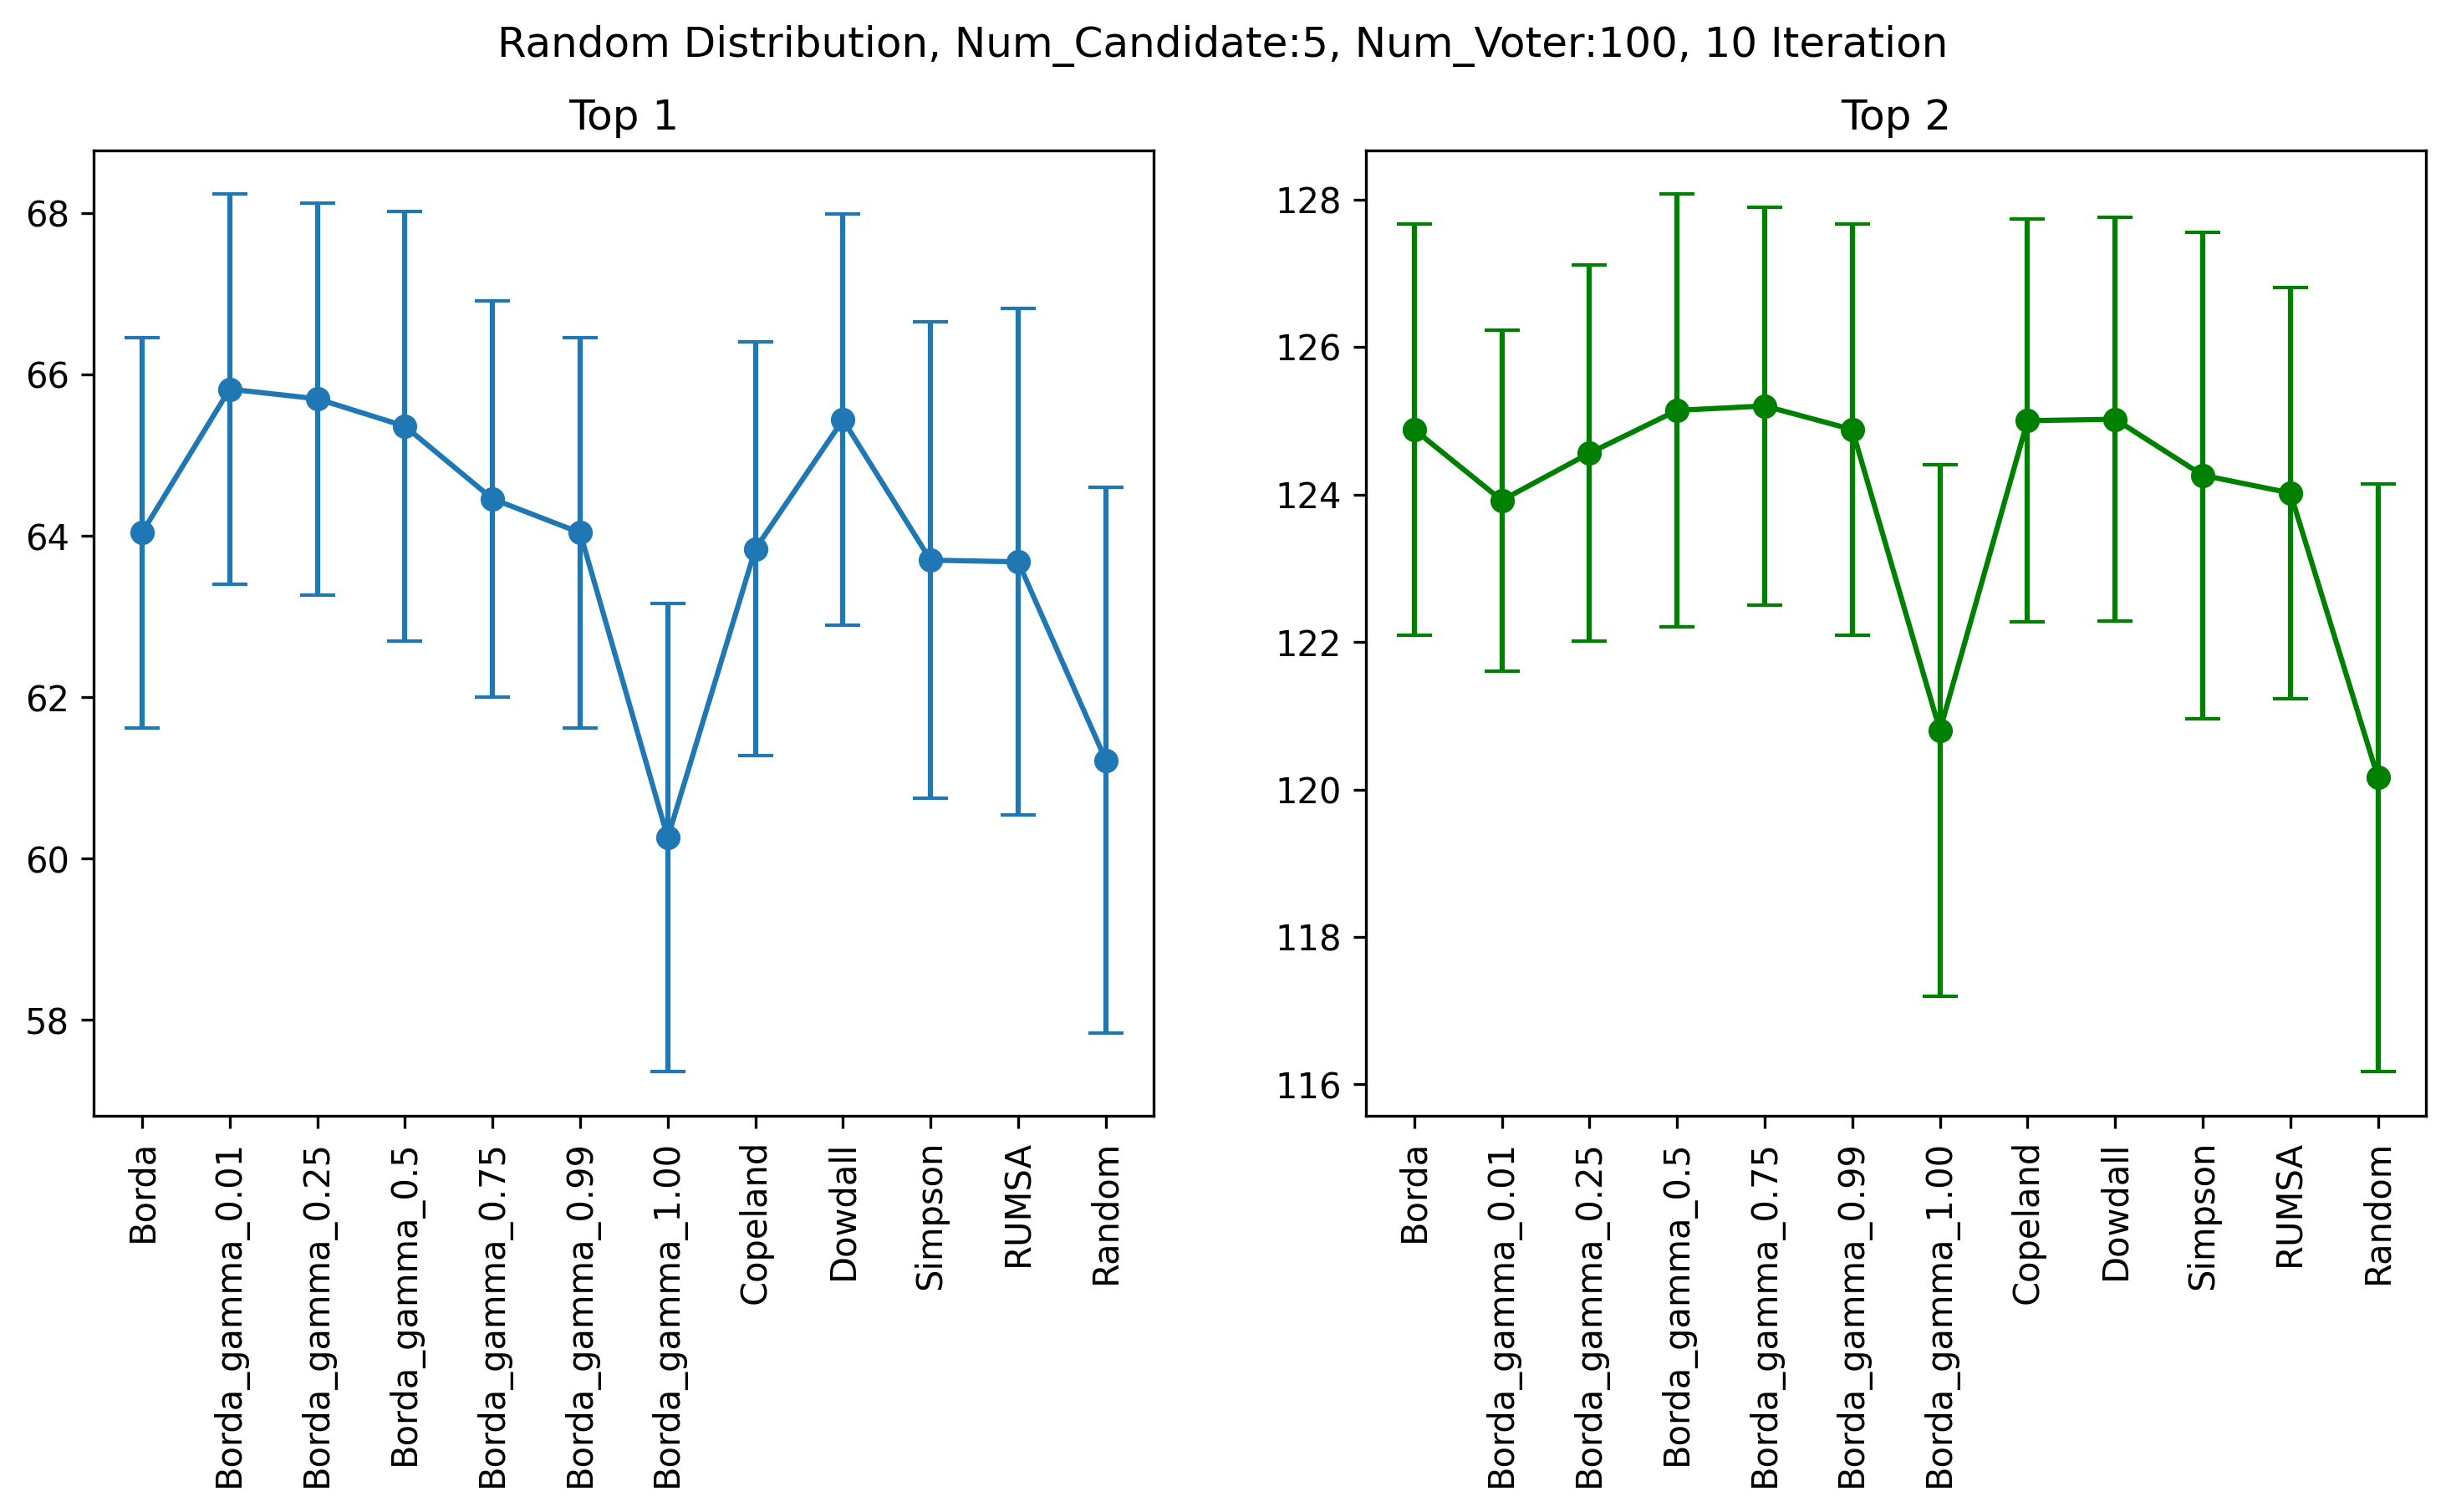

In [15]:
tn_rand_avgs = []
tn_rand_stds = []
t_rand_avgs = []
t_rand_stds = []

for k in test_rules.keys():
    data = rand_results[k]
    tops = []
    topns = []
    for i in data:
        tops.append(i['top'])
        topns.append(i['topn'])
    t_rand_avgs.append(np.mean(tops))
    t_rand_stds.append(np.std(tops))
    tn_rand_avgs.append(np.mean(topns))
    tn_rand_stds.append(np.std(topns))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

fig.suptitle('Random Distribution, Num_Candidate:5, Num_Voter:100, 10 Iteration')

ax1.errorbar(np.arange(len(t_rand_avgs)), t_rand_avgs, yerr=t_rand_stds, fmt='o-', capsize=5)
ax1.set_title('Top 1')
ax1.set_xticks(np.arange(len(t_rand_avgs)))
ax1.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')

ax2.errorbar(np.arange(len(tn_rand_avgs)), tn_rand_avgs, yerr=tn_rand_stds, fmt='o-', capsize=5, color="green")
ax2.set_title('Top 2')
ax2.set_xticks(np.arange(len(tn_rand_avgs)))
ax2.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')

plt.show()


[Text(0, 0, 'Borda'),
 Text(1, 0, 'Borda_gamma_0.01'),
 Text(2, 0, 'Borda_gamma_0.25'),
 Text(3, 0, 'Borda_gamma_0.5'),
 Text(4, 0, 'Borda_gamma_0.75'),
 Text(5, 0, 'Borda_gamma_0.99'),
 Text(6, 0, 'Borda_gamma_1.00'),
 Text(7, 0, 'Copeland'),
 Text(8, 0, 'Dowdall'),
 Text(9, 0, 'Simpson'),
 Text(10, 0, 'RUMSA'),
 Text(11, 0, 'Random')]

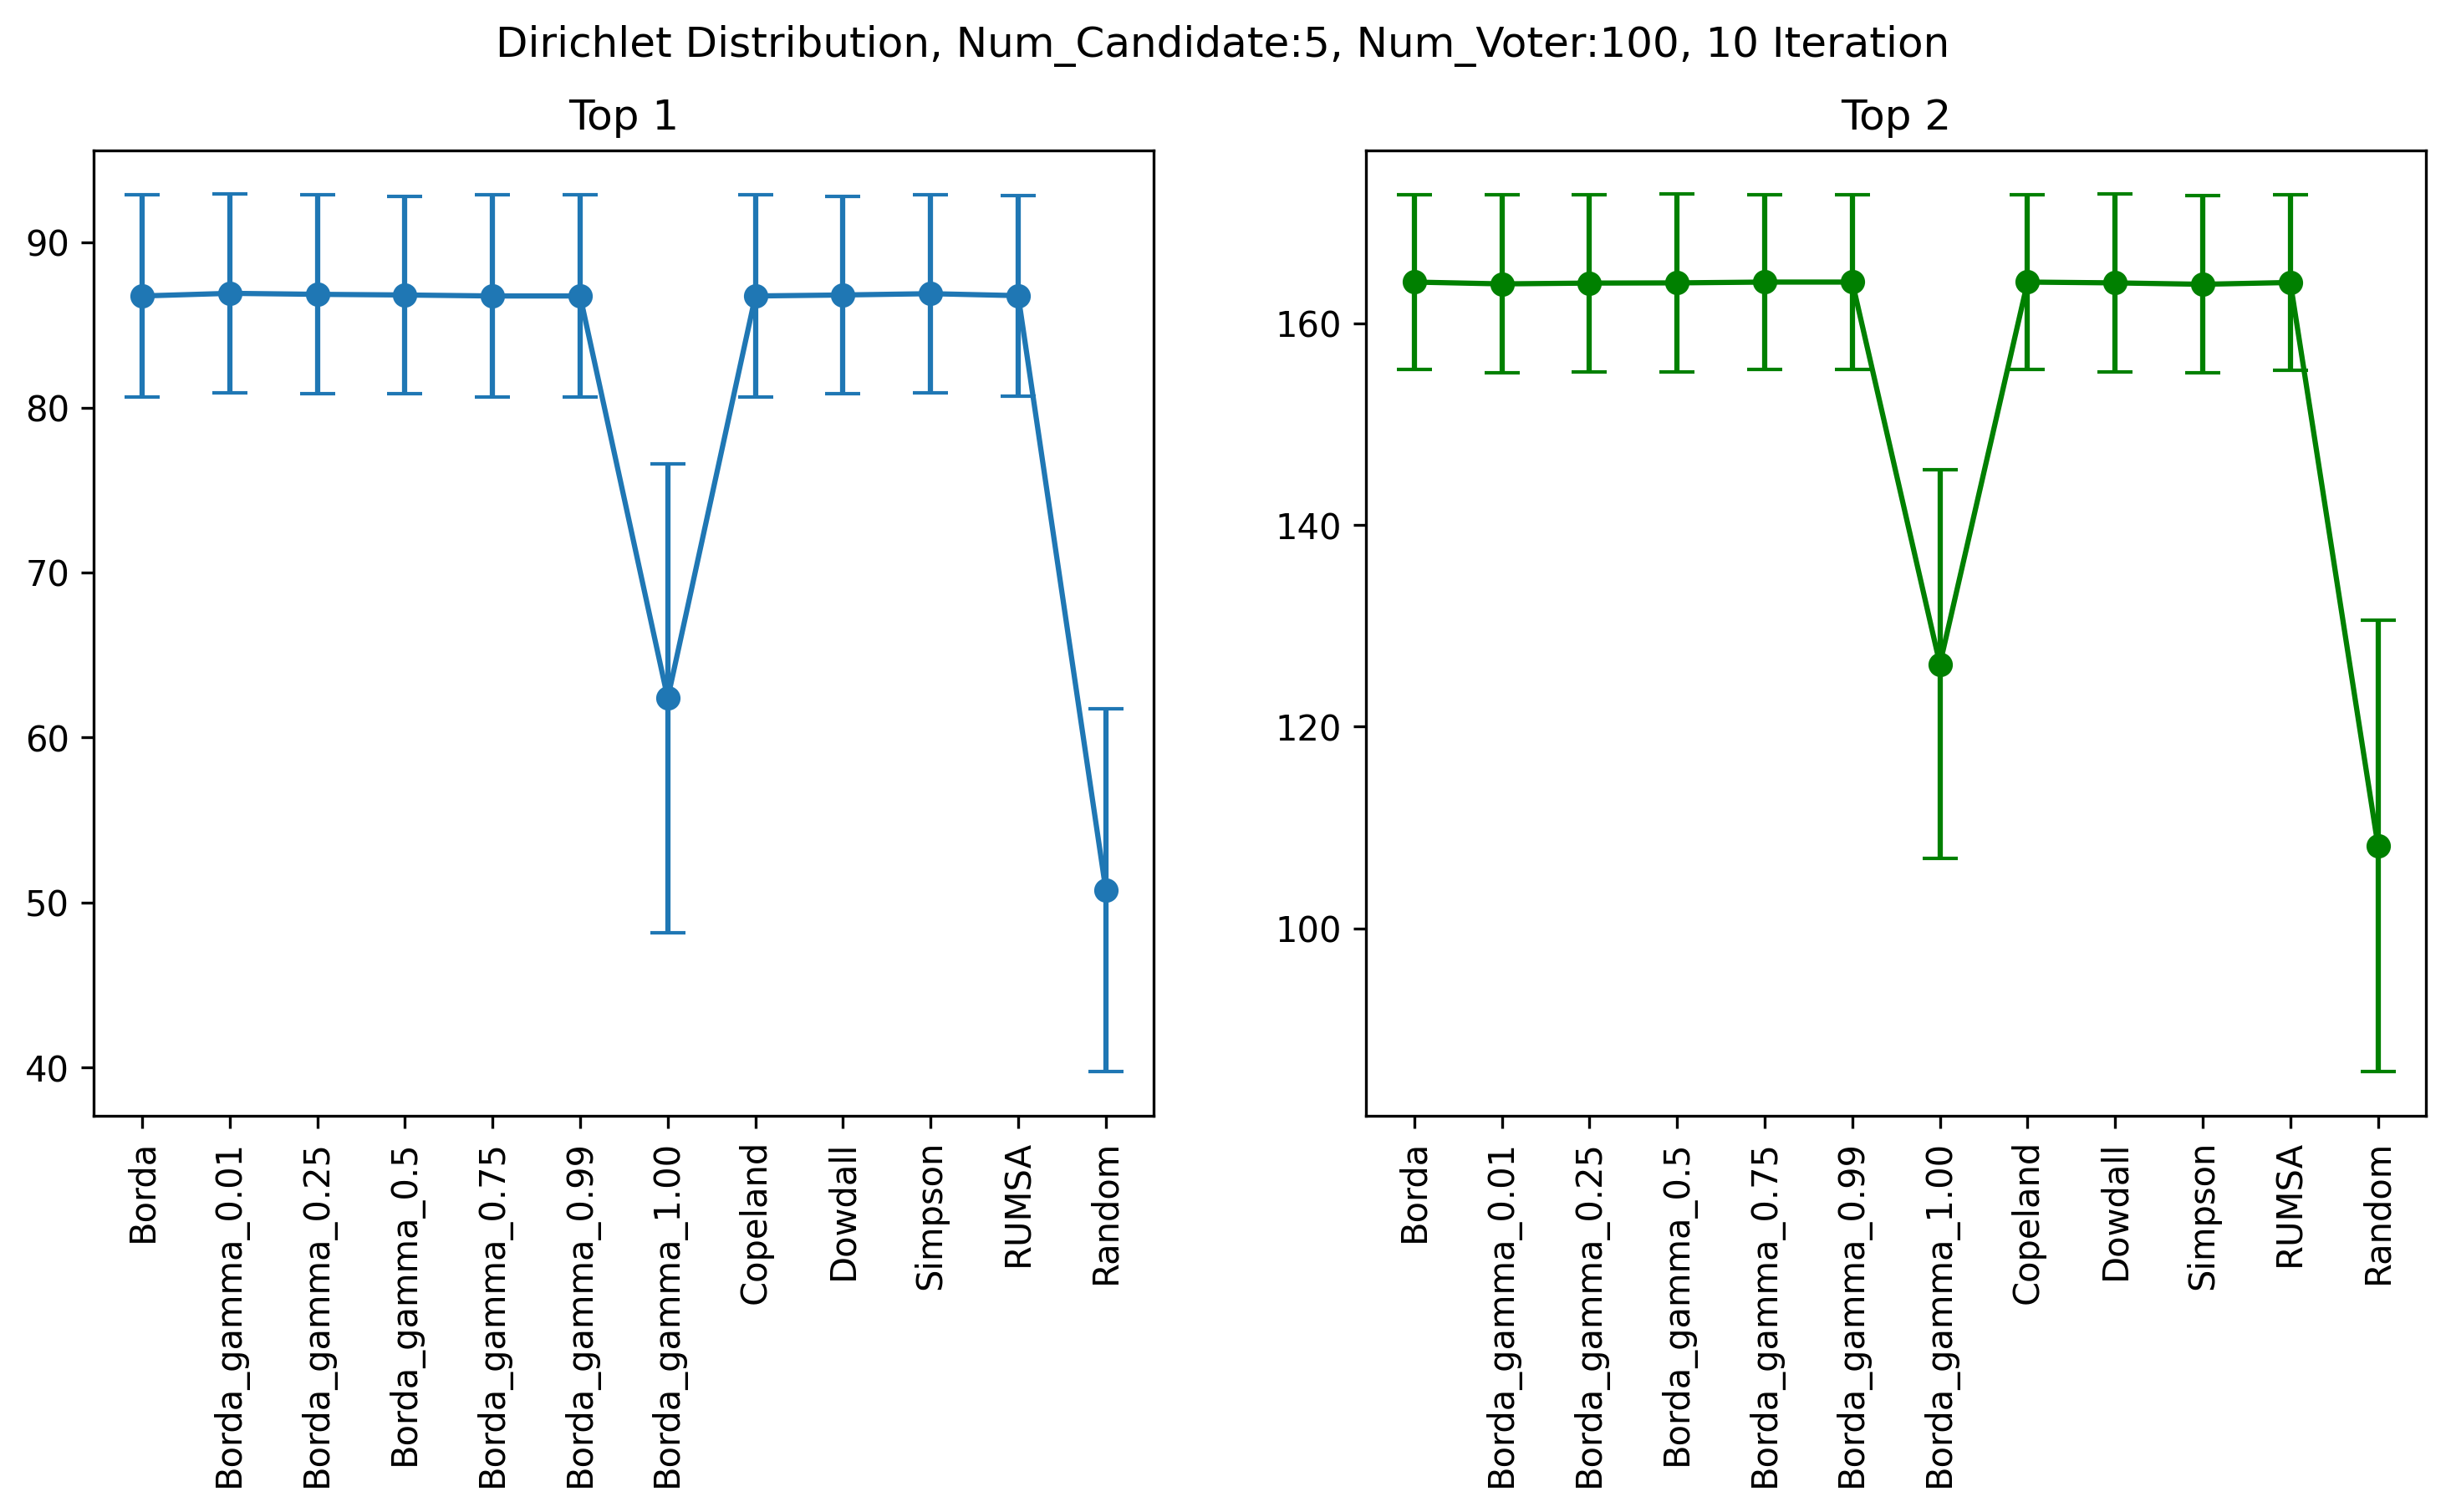

In [16]:
tn_diri_avgs = []
tn_diri_stds = []
t_diri_avgs = []
t_diri_stds = []

for k in test_rules.keys():
    data = diri_results[k]
    tops = []
    topns = []
    for i in data:
        tops.append(i['top'])
        topns.append(i['topn'])
    t_diri_avgs.append(np.mean(tops))
    t_diri_stds.append(np.std(tops))
    tn_diri_avgs.append(np.mean(topns))
    tn_diri_stds.append(np.std(topns))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

fig.suptitle('Dirichlet Distribution, Num_Candidate:5, Num_Voter:100, 10 Iteration')

ax1.errorbar(np.arange(len(t_diri_avgs)), t_diri_avgs, yerr=t_diri_stds, fmt='o-', capsize=5)
ax1.set_title('Top 1')
ax1.set_xticks(np.arange(len(t_diri_avgs)))
ax1.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')

ax2.errorbar(np.arange(len(tn_diri_avgs)), tn_diri_avgs, yerr=tn_diri_stds, fmt='o-', capsize=5, color="green")
ax2.set_title('Top 2')
ax2.set_xticks(np.arange(len(tn_diri_avgs)))
ax2.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')

[Text(0, 0, 'Borda'),
 Text(1, 0, 'Borda_gamma_0.01'),
 Text(2, 0, 'Borda_gamma_0.25'),
 Text(3, 0, 'Borda_gamma_0.5'),
 Text(4, 0, 'Borda_gamma_0.75'),
 Text(5, 0, 'Borda_gamma_0.99'),
 Text(6, 0, 'Borda_gamma_1.00'),
 Text(7, 0, 'Copeland'),
 Text(8, 0, 'Dowdall'),
 Text(9, 0, 'Simpson'),
 Text(10, 0, 'RUMSA'),
 Text(11, 0, 'Random')]

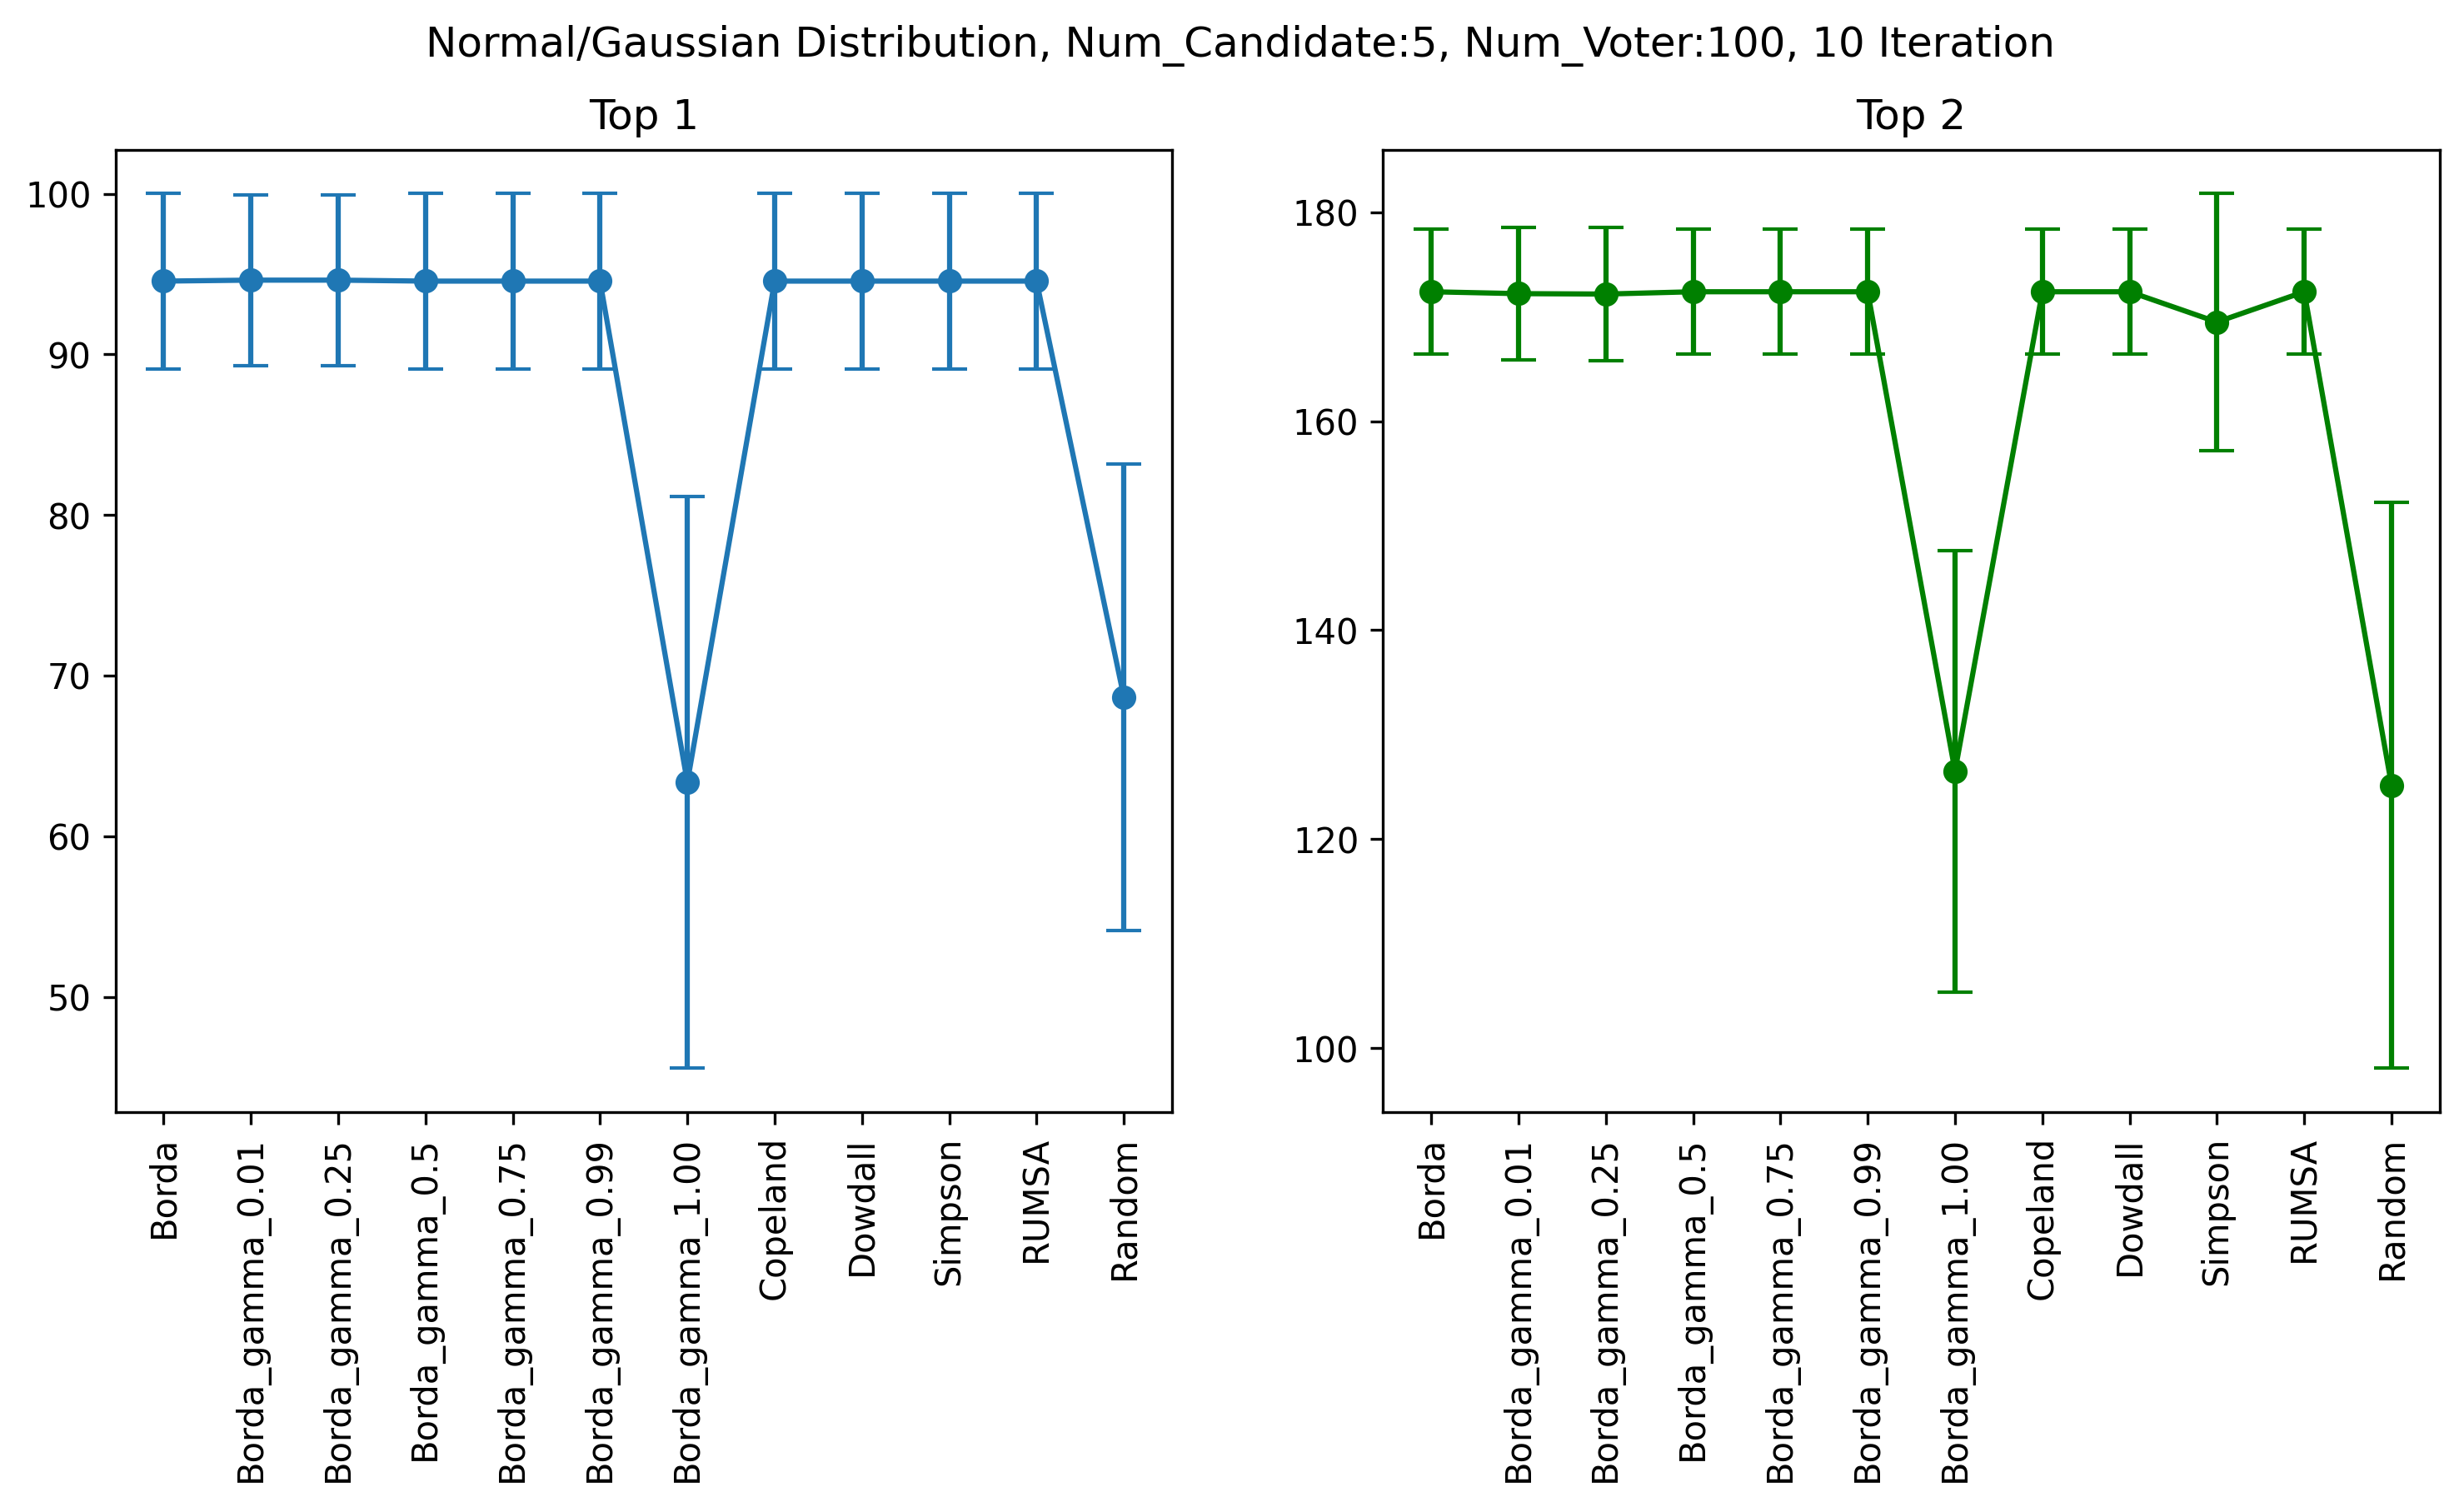

In [17]:
tn_norm_avgs = []
tn_norm_stds = []
t_norm_avgs = []
t_norm_stds = []

for k in test_rules.keys():
    data = norm_results[k]
    tops = []
    topns = []
    for i in data:
        tops.append(i['top'])
        topns.append(i['topn'])
    t_norm_avgs.append(np.mean(tops))
    t_norm_stds.append(np.std(tops))
    tn_norm_avgs.append(np.mean(topns))
    tn_norm_stds.append(np.std(topns))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

fig.suptitle('Normal/Gaussian Distribution, Num_Candidate:5, Num_Voter:100, 10 Iteration')

ax1.errorbar(np.arange(len(t_norm_avgs)), t_norm_avgs, yerr=t_norm_stds, fmt='o-', capsize=5)
ax1.set_title('Top 1')
ax1.set_xticks(np.arange(len(t_norm_avgs)))
ax1.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')

ax2.errorbar(np.arange(len(tn_norm_avgs)), tn_norm_avgs, yerr=tn_norm_stds, fmt='o-', capsize=5, color="green")
ax2.set_title('Top 2')
ax2.set_xticks(np.arange(len(tn_norm_avgs)))
ax2.set_xticklabels([k for k in test_rules.keys()], rotation='vertical')